<a href="https://colab.research.google.com/github/NataliaKurd/transformers_end_assignment/blob/main/transfomers_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfomers: Exploration of memorization in Large Language Models

**Group members:**
- Natalia Kurdanova 1796550
- Jefry el Bhwash 9495495
- Sjardi Djoy Willems 7424442
- Sean van der Tuin 8087287

**Introduction to the notebook**

In order to generate the ouput follow the steps below:
1. Adjust variables in 'block with variables' (it is located after imports)
2. Run: imports, 'block with variables' and download data section
3. Run: section 'loading the model and prompting it'


**Distribution of datasets**

- Natalia - prompts_100
- Jefry - prompts_150
- Sjardi - prompts_250
- Sean - prompts_200

In [ ]:
import numpy as np
import pandas as pd
import random
import tqdm
import re
import time

from google.colab import files

from matplotlib import pyplot as plt
from collections import Counter

from transformers import GPTNeoForCausalLM, GPT2Tokenizer, GenerationConfig
import torch

import nltk
from nltk.corpus import stopwords

**Block with variables**

In [ ]:
# variables

colab = True                                                      # if you run locally, set to False

sequence_length = 250                                             # sequence lenght from the name of the file
p = 50                                                            # length of the new ouput generated by the model
prompt_length = sequence_length - p                               # length of the prompt that is provided to the model

number_of_iterations = 1000                                    # number of iterations/ outputs
save_every = 200                                            # new file is created every n number of iterations

prompts_file_path = 'prompts_' + str(sequence_length) + '.npy'    # name of the prompt file
counts_file_path = 'counts_' + str(sequence_length) + '.npy'      # name of the counts file

model_name = 'EleutherAI/gpt-neo-1.3B'                            # name of the model

## 0. Download data

In this section we download data to the notebook.  
**Action:** add required files to google colab 'files' section. You can find files [here](https://github.com/ethz-spylab/lm_memorization_data)

In [ ]:
data_p = np.load(prompts_file_path)
data_c = np.load(counts_file_path)

In [ ]:
data_p.shape, data_c.shape

((52000, 250), (52000,))

In [ ]:
data_p[199]

array([ 4058,    13,   198,   198,  2025, 20057,   338, 22358,  4803,
          38, 35409,  4221,  2606,  5188,     3,   198,   198,     7,
         220,   402,  6684,    38,  2538, 34645,  1267,  2162,   220,
        4064,  2919,  2624,    12, 27019,  1433,  1795,    26, 26794,
         893,  5162,   395,  4803,    31,   445,   733,  4529,    13,
         785,    26,   311,  1142,   397,   265,   320,  8511,    26,
         288,  2343,   224,   117, 33698,    11,   351,  7125,  2343,
         224,   117, 39188,    26,   220,   257,   370,     8,   198,
         198,  3198,   286,   257, 10089,   286,  4113, 20883,   311,
        1142,   397,   265,   320,  8511,    11,  8451,    88,   338,
         318,   257, 12507,   351, 37217,   329,   663,   922,  7072,
          11,  1492,  5163,   290,   880,    12, 45089,   442,   282,
         316,    12,  7635,  9519,    11,   543,  7539,   736,   422,
         262, 10481,    11, 11191,   416,   257, 11376,    13, 13709,
         333,  1079,

## 1. Data exploration

In this section we explore the data: most frequent words, word count, avg length etc.

In [ ]:
data_prompts = data_p.copy()
data_counts = data_c.copy()

In [ ]:
vocab = GPT2Tokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

In [ ]:
decoded_data = []

for ids in tqdm.tqdm(data_prompts):
  decoded_data.append(vocab.decode(ids, skip_special_tokens=True))

100%|██████████| 52000/52000 [03:24<00:00, 254.71it/s]


In [ ]:
decoded_data = np.asarray(decoded_data)
decoded_data[199]

" ahead.\n\nAnthy's GuesthouseGUESTHOUSE$\n\n(  GOOGLE MAP ) ;  %0832-2771680; anthysguesthouse@rediffmail.com; Sernabatim Beach; d ₹1500, with AC ₹1800;  a W)\n\nOne of a handful of places lining Sernabatim Beach, Anthy's is a favourite with travellers for its good restaurant, book exchange and well-kept chalet-style rooms, which stretch back from the beach, surrounded by a garden. Ayurvedic massage is available.\n\n oBlue CornerHUT$$\n\n(  GOOGLE MAP ) ;  %9850455770; www.bluecornergoa.com; huts ₹1200;  W)\n\nBehind the beach shack restaurant a short walk north of the main beach entrance, this group of sturdy palm-thatch cocohuts – not so common around here – are the best in Benaulim, with fan and verandah. The restaurant gets good reviews from guests.\n\nTaj ExoticaHOTEL$$$\n"

### 1.1. Data visualization

In [ ]:
# top the most frequent sequences
sorted_freq = np.argsort(data_counts)[-50:]

In [ ]:
data_counts[sorted_freq]

array([304413, 304736, 305235, 305256, 305947, 306152, 306241, 306366,
       306455, 306508, 306638, 306885, 306971, 307009, 307035, 307063,
       307373, 308155, 308230, 308367, 308390, 308692, 309099, 309594,
       309885, 310136, 310330, 310406, 310516, 310572, 310666, 310746,
       310856, 311078, 311322, 311489, 311547, 311591, 312132, 312203,
       312411, 312425, 312563, 312592, 312687, 312831, 312868, 313088,
       313270, 348221])

In [ ]:
# We have duplicates because we do not have special tokens in the decoded data
print('Number of duplicated sequences: ', len(decoded_data) - len(set(decoded_data)))

Number of duplicated sequences:  20


In [ ]:
# clean the data
cleaned_data = []
regex_string = r'[^\w\s]|[\n]|(\s)(i|1|2|0|if|by|are|at|is|a|an|and|the|of|to|and|in|is|or|for|you|he|she|it|this|that|with|be|on)(\s)'

for sequence in tqdm.tqdm(decoded_data):
  sequence = sequence.lower()
  cleaned_data.append(re.sub(regex_string, ' ', sequence))

100%|██████████| 52000/52000 [00:06<00:00, 8288.28it/s]


In [ ]:
cleaned_data = np.asarray(cleaned_data)
cleaned_data[199]

' ahead   anthy s guesthouseguesthouse      google map       0832 2771680  anthysguesthouse rediffmail com  sernabatim beach  d  1500  ac  1800   w   one a handful places lining sernabatim beach  anthy s a favourite travellers its good restaurant  book exchange well kept chalet style rooms  which stretch back from beach  surrounded a garden  ayurvedic massage available    oblue cornerhut       google map       9850455770  www bluecornergoa com  huts  1200   w   behind beach shack restaurant short walk north the main beach entrance  group sturdy palm thatch cocohuts   not so common around here   the best benaulim  fan verandah  restaurant gets good reviews from guests   taj exoticahotel    '

In [ ]:
df = pd.DataFrame(cleaned_data)
df['Length'] = df[0].apply(len)
df['Word_Count'] = df[0].str.split().apply(len)

In [ ]:
df.sort_values(by='Word_Count', ascending=False).head(15)

,0,Length,Word_Count
51904,drip drip drip drip drip drip drip drip drip ...,1250,250
44427,x x x x x x x x x x x x x x x x x x x x x x x...,500,250
34134,million million million million million milli...,2000,250
33798,5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5...,500,250
50748,000 000 000 000 000 000 000 000 000 000 000 0...,1000,250
39097,c so c so c so c so c so c so c so c so c so ...,592,237
39856,c so c so c so c so c so c so c so c so c so ...,592,237
39450,so c so c so c so c so c so c so c so c so c s...,592,237
39604,so c so c so c so c so c so c so c so c so c ...,593,237
39428,c so c so c so c so c so c so c so c so c so ...,592,237


In [ ]:
df.describe()

,Length,Word_Count
count,52000.000000,52000.000000
mean,576.805615,69.049385
std,252.329112,45.154178
min,63.000000,0.000000
25%,400.000000,35.000000
50%,535.000000,62.000000
75%,730.000000,100.000000
max,16000.000000,250.000000


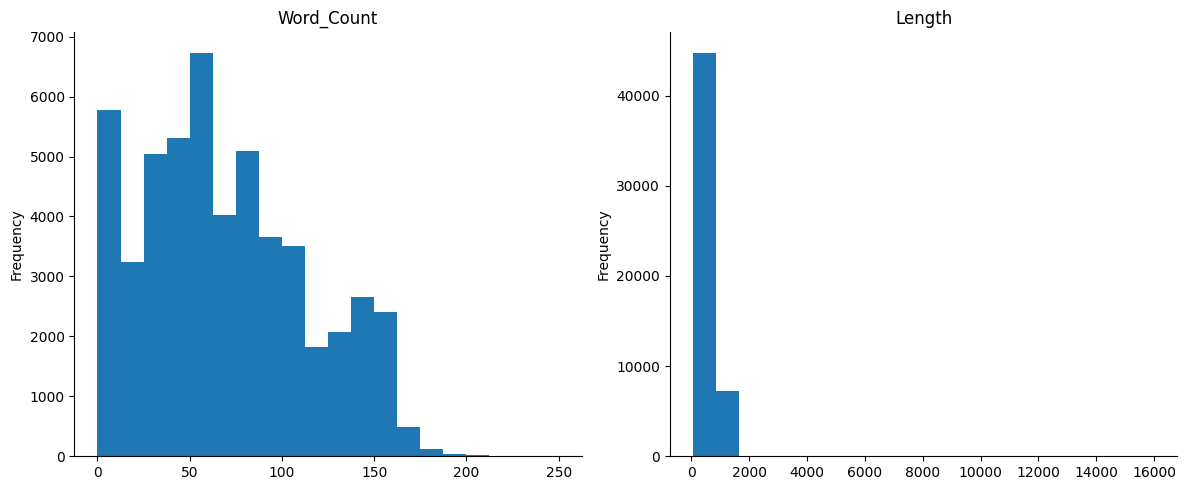

In [ ]:
# word count and lenght of the sequences

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

df['Word_Count'].plot(kind='hist', bins=20, title='Word_Count', ax=axes[0])
axes[0].spines[['top', 'right']].set_visible(False)

df['Length'].plot(kind='hist', bins=20, title='Length', ax=axes[1])
axes[1].spines[['top', 'right']].set_visible(False)

plt.tight_layout()
#plt.savefig('word_count.png')
plt.show()

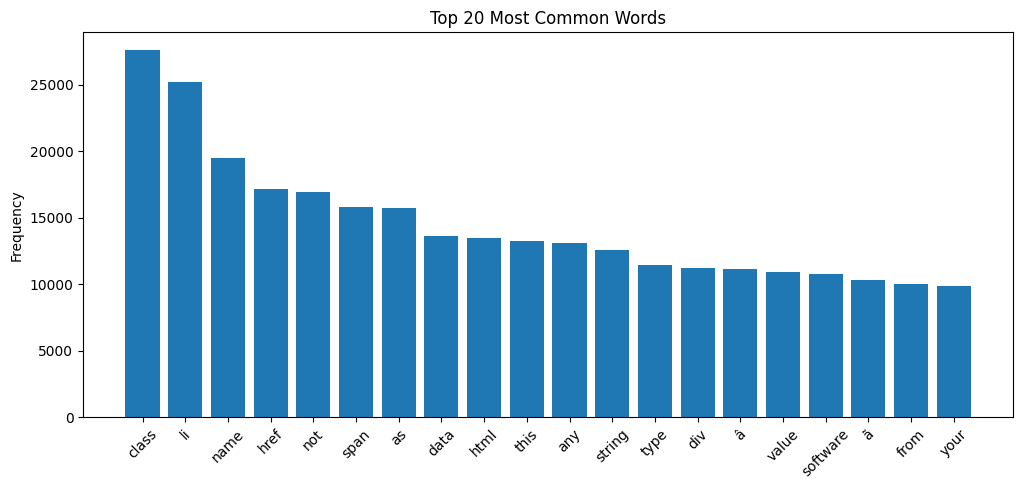

In [ ]:
# most common words

all_words = [word for sentence in df[0] for word in sentence.split() if not word in ['the', '0', 'a', '1', '2', 'i', 's', 'you', 'is']]
word_counts = Counter(all_words)

top_n = 20
most_common_words = word_counts.most_common(top_n)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 5))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
#plt.savefig('top_words.png')
plt.show()

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
filtered_sentence = [w for w in all_words if not w.lower() in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[('class', 27567), ('li', 25200), ('name', 19507), ('href', 17130), ('span', 15761), ('data', 13606), ('html', 13482), ('string', 12556), ('type', 11442), ('div', 11179), ('â', 11129), ('value', 10881), ('software', 10734), ('ã', 10281), ('xsd', 9652), ('3', 8981), ('use', 8972), ('n', 8695), ('license', 8617), ('td', 8195)]


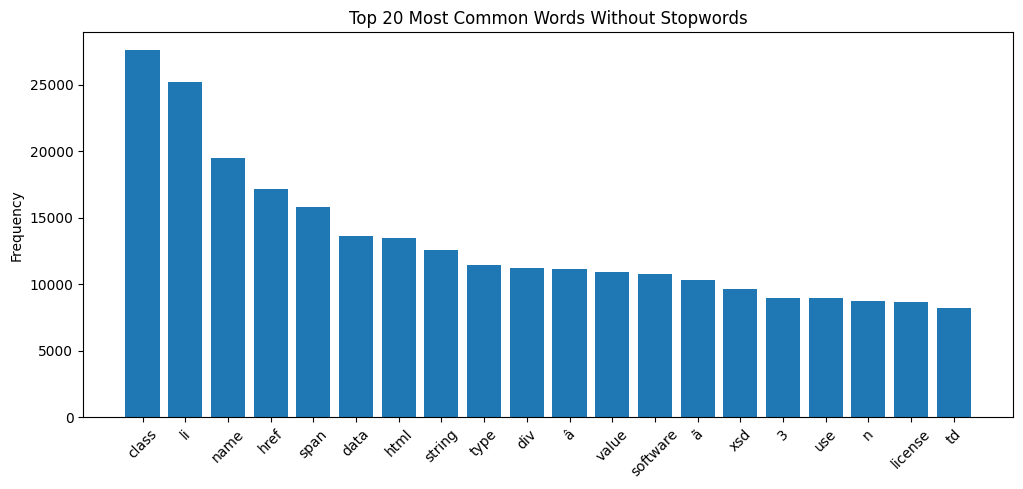

In [ ]:
# without stop words

import matplotlib.pyplot as plt

word_counts = Counter(filtered_sentence)
print(word_counts.most_common(20))

top_n = 20
most_common_words = word_counts.most_common(top_n)
words, counts = zip(*most_common_words)

plt.figure(figsize=(12, 5))
plt.bar(words, counts)
plt.title('Top 20 Most Common Words Without Stopwords')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
#plt.savefig('top_words2.png')
plt.show()

In [ ]:
# unique words

unique_words = set(all_words)
print(f'Number of unique words: {len(unique_words)}')

Number of unique words: 178010


## 2. Loading the model and prompt it


Now we will try to promt the model with data from prompts file. As a prompt we will use the first (sequence_length - p) tokens of the sequence. We restrict the model, so, it generates exactly p tokens.

In [ ]:
data_prompts = data_p.copy()
data_counts = data_c.copy()

In [ ]:
model = GPTNeoForCausalLM.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

### 2.1 One prompt

In [ ]:
sequence = torch.tensor(torch.from_numpy(data_prompts[199][:prompt_length].astype(int)))
sequence = sequence.reshape(1, -1)
sequence

<ipython-input-26-495f3da0081d>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence = torch.tensor(torch.from_numpy(data_prompts[199][:prompt_length].astype(int)))


tensor([[ 4058,    13,   198,   198,  2025, 20057,   338, 22358,  4803,    38,
         35409,  4221,  2606,  5188,     3,   198,   198,     7,   220,   402,
          6684,    38,  2538, 34645,  1267,  2162,   220,  4064,  2919,  2624,
            12, 27019,  1433,  1795,    26, 26794,   893,  5162,   395,  4803,
            31,   445,   733,  4529,    13,   785,    26,   311,  1142,   397,
           265,   320,  8511,    26,   288,  2343,   224,   117, 33698,    11,
           351,  7125,  2343,   224,   117, 39188,    26,   220,   257,   370,
             8,   198,   198,  3198,   286,   257, 10089,   286,  4113, 20883,
           311,  1142,   397,   265,   320,  8511,    11,  8451,    88,   338,
           318,   257, 12507,   351, 37217,   329,   663,   922,  7072,    11,
          1492,  5163,   290,   880,    12, 45089,   442,   282,   316,    12,
          7635,  9519,    11,   543,  7539,   736,   422,   262, 10481,    11,
         11191,   416,   257, 11376,    13, 13709,  

In [ ]:
output = model.generate(sequence, max_new_tokens=p, min_new_tokens=p, eos_token_id=model.config.eos_token_id,
    pad_token_id=model.config.eos_token_id)
output_d = tokenizer.decode(output[0])

In [ ]:
output_d

" ahead.\n\nAnthy's GuesthouseGUESTHOUSE$\n\n(  GOOGLE MAP ) ;  %0832-2771680; anthysguesthouse@rediffmail.com; Sernabatim Beach; d ₹1500, with AC ₹1800;  a W)\n\nOne of a handful of places lining Sernabatim Beach, Anthy's is a favourite with travellers for its good restaurant, book exchange and well-kept chalet-style rooms, which stretch back from the beach, surrounded by a garden. Ayurvedic massage is available.\n\n oBlue CornerHUT$$\n\n(  GOOGLE MAP ) ;  %9850455770; www.bluecornergoa.com; huts ₹1200;  W)\n\nBehind the beach shack restaurant a short walk north of the main beach entrance, this group of sturdy, well-kept, air-conditioned huts is a great place to stay. The huts are set in a garden with a pool and a hammock.\n\n5Eating\n\nThe beach is lined with restaurants, but the"

### 2.2 Loop function for the whole dataset

In [ ]:
def decode_file(file):

    decoded_data = []

    for ids in tqdm.tqdm(data_prompts):
      decoded_data.append(vocab.decode(ids, skip_special_tokens=True))

    return decoded_data

def generate_output(input_data, n_iter, prompt_length, p):
    """
    Generates ouput from the model.

    :input_data: list with input sequences
    :n_iter: number of interations/ outputs
    :prompt_lenght: lenght of the part of the sequences that is used for prompting
    :p: number of tokens generated by model
    """

    result = []

    input_data = input_data.copy()

    for sequence, i in zip(tqdm.tqdm(input_data[:n_iter]), range(1, n_iter + 1)):

      prompt = torch.from_numpy(sequence[:prompt_length].astype(int)).reshape(1, -1)

      output = model.generate(prompt, max_new_tokens=p, min_new_tokens=p, eos_token_id=model.config.eos_token_id,
        pad_token_id=model.config.eos_token_id)

      output_last_p = output.numpy()[0][prompt_length:]
      sequence_last_p = sequence[prompt_length:]

      memorization = 1 if (output_last_p == sequence_last_p).all() else 0

      result.append([sequence, output.numpy()[0], memorization])

      if i % save_every == 0:
        df = pd.DataFrame(result)
        df.to_csv('output_' + str(sequence_length) + '_' + str(i) + '.csv')
        if colab:
          files.download('output_' + str(sequence_length) + '_' + str(i) + '.csv')

    return result

In [ ]:
output = generate_output(data_prompts, number_of_iterations, prompt_length, p)

 40%|████      | 4/10 [00:44<01:07, 11.21s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 90%|█████████ | 9/10 [01:39<00:11, 11.07s/it]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

100%|██████████| 10/10 [01:51<00:00, 11.12s/it]


In [ ]:
df = pd.DataFrame(output)
df.to_csv('output_' + str(sequence_length) + '_' + 'final' + '.csv')
if colab:
  files.download('output_' + str(sequence_length) + '_' + 'final' + '.csv')

## Appendix 1

In [ ]:
output_encoded = []
output_decoded = []
counter = 0

for sequence in tqdm.tqdm(data_prompts[:number_of_iterations]):

    prompt = torch.from_numpy(sequence[:prompt_length].astype(int)).reshape(1, -1)

    output = model.generate(prompt, max_new_tokens=p, min_new_tokens=p, eos_token_id=model.config.eos_token_id,
      pad_token_id=model.config.eos_token_id)

    if (output.numpy()[0][prompt_length:] == sequence[prompt_length:]).all():
      counter += 1

    output_d = tokenizer.decode(output[0])
    input_d = tokenizer.decode(sequence)

    print('Counter ', counter)
    print('\n' + 'Input: ' + input_d + '\n' + 'Output: ' + output_d + '\n ---------- \n')

    output_encoded.append(output)
    output_decoded.append(output_d)